# Домашнее задание 3

Это домашнее задание по материалам второго семинаров. Дедлайн по отправке - 23:55 24 февраля. 

Домашнее задание выполняется в этом же Jupyter Notebook'e и присылается мне на почту: __beznosikov.an@phystech.edu__.

Решение каждой задачи необходимо поместить после её условия.

Файл должен называться: Фамилия_Имя_Optimization_HW_3

При полном запуске Вашего решения (Kernel -> Restart & Run All) все ячейки должны выполняться без ошибок. 

## Задача 1

Вновь рассмотрим задачу минимизации эмпирического риска:
\begin{equation}
\min_{w \in \mathbb{R}^d} \frac{1}{n} \sum\limits_{i=1}^n l (g(w, x_i), y_i).
\end{equation}

В прошлом задании работа шла с линейной модель $g(w, x) = w^T x$ и квадратичную функцию потерь $l(z, y) = (z-y)^2$. 

__(а)__ В дополнение к квадратичной функции потерь реализуйте логистическую/сигмоидную: $l(z,y) = \ln (1 + \exp(-yz))$ (__Важно: $y$ должен принимать значения -1 или 1__). Выпишите градиент. Является ли новая задача регресии выпуклой? Оцените $L$ для новой функции потерь. 

$f =  \dfrac{1}{n}\sum\limits_{i=1}^n \ln(1+\exp(-w^Tx_iy_i))$

$\nabla f =  -\dfrac{1}{n}\sum\limits_{i=1}^n \dfrac{1}{1 + e^{w^Tx_iy_i}}x_iy_i$

$\nabla^2 f = \dfrac{1}{n}\sum\limits_{i=1}^n \dfrac{e^{w^Tx_iy_i}}{(1 + e^{w^Tx_iy_i})^2}(x_ix_i^T) y_i^2$

Задача является выпуклой, поскольку гессиан неотрицательно определен:

$w^Tx_ix_i^Tw = ||w^Tx_i||^2 \geq 0$ + все коэффициенты неотрицательны.

Для оценки $L$ положим $w = 0$. 

Тогда для вычисления $L$ нужно найти $\lambda_{max}$ гессиана:

$\nabla^2 f = \dfrac{1}{4n}\sum\limits_1^n y_i^2x_ix_i^T$

__(б)__ Возьмите датасет _mushrooms_ из прошлого задания. Проделайте следующие шаги из прошлого задания, только с логистической функцией потерь:

1) Разделите данные на две части: обучающую и тестовую.

2) Для обучающей части $X_{train}$, $y_{train}$ оцените константу $L$ задачи обучения/оптимизации.

3) Используя градиентный спуск, обучите новую модель (без ограничений и регуляризаций). Постройте график: точность от номера итерации.

4) Если в пункте 3) пришлось столкнуться с проблемами или просто необходимо улучшить точность, то добавьте ограничения или $\ell_2$-регуляризацию, как в прошлом ДЗ.

5) Сравните с результатами квадратичной функции потерь из прошлого ДЗ.

In [1]:
# читаем
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.datasets import load_svmlight_file

dataset = "mushrooms.txt"
data = load_svmlight_file(dataset)
X, y = data[0].toarray(), data[1]

# {1,2} -> {-1, 1}
y = 2 * y - 3

# n - число наблюдений, d - признаков
n, d = X.shape

In [2]:
# делим
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True)
print(f"train data len: {len(X_train)}")
print(f"test data len: {len(X_test)}")

train data len: 6499
test data len: 1625


In [4]:
# гессиан при w = 0

hessian = np.zeros((d, d))
for i in range(X_train.shape[0]):
    hessian += X_train[i].reshape((d, 1)) @ X_train[i].reshape((1, d))
hessian = hessian / (4 * X_train.shape[0])

In [6]:
print(np.amax(np.linalg.eigvals(hessian)))
L = 2.58

(2.587756268864849+0j)


In [7]:
from numba import jit

@jit
def f(w, X=X, y=y):
    Q = 0
    for i in range(X.shape[0]):
        Q += np.log(1 + np.exp(-y[i] * (w.T @ X[i])))
    return Q/X.shape[0]

@jit
def grad(w, X=X, y=y):
    g = np.zeros(w.shape)
    for i in range(X.shape[0]):
        g += y[i] * X[i] / (1 + np.exp(y[i] * w.T @ X[i]))
    return -g/X.shape[0]

In [8]:
# 0.388 = 1/2.58 = 1/L
def grad_descent(gamma=1/L, iters=1000):

    w = np.random.uniform(low=-L/5, high=L/5, size=(d,))
    f_vals = [f(w)]
    w_vals = [w]

    for i in range(iters):
        w = w - gamma * grad(w, X=X_train, y=y_train)
        w_vals.append(w)
        f_vals.append(f(w, X=X_train, y=y_train))
        
    print(f"Finished at:\n f(w*) = {f(w)}")
    return w_vals, f_vals

iters = 2000
w_gd, f_gd = grad_descent(iters=iters)

Finished at:
 f(w*) = 0.014370335452554724


Воспользуемся критерием $|f(x^{k+1}) - f(x^k)|.$

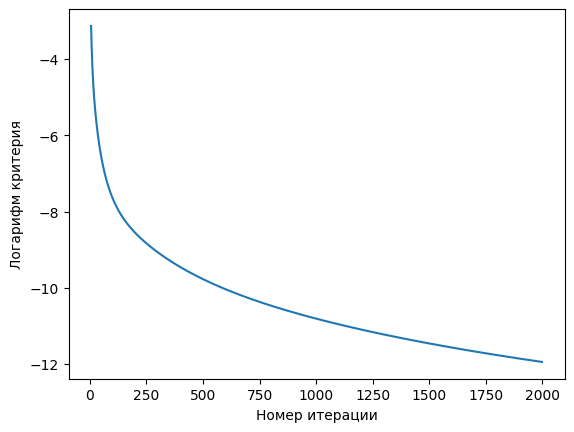

In [9]:
err = [abs(f_gd[k+1] - f_gd[k]) for k in range(5, iters)]

plt.plot(range(5, iters), np.log(err))
plt.xlabel("Номер итерации")
plt.ylabel("Логарифм критерия")
plt.show()

In [10]:
from sklearn.metrics import accuracy_score

def acc_score(w):
    train = accuracy_score(y_train, np.around(2 / (1 + np.exp(- X_train @ w))) - 1)
    test = accuracy_score(y_test, np.around(2 / (1 + np.exp(- X_test @ w))) - 1)
    return train, test

w = w_gd[-1]
train1, test1 = acc_score(w)
print(f"Train accuracy: {train1}")
print(f"Test accuracy: {test1} \n")

Train accuracy: 0.9944606862594245
Test accuracy: 0.9975384615384615 



Сходится увереннее, чем во 2 дз: значение критерия падает значительно быстрее, хвост логарифмического графика лучше приближается прямой. 

Точность (test accuracy) выше, чем с квадратичным лоссом.

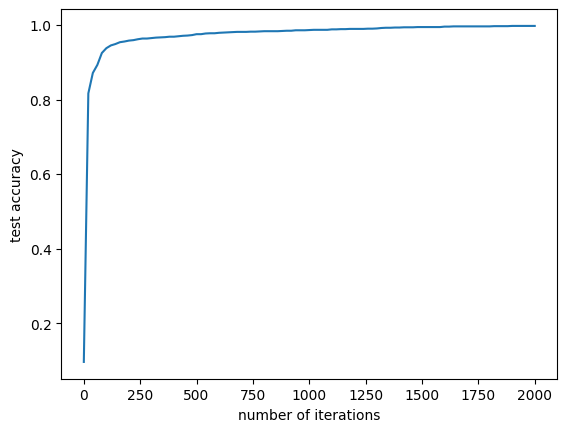

In [11]:
acc = list()
n = list()
for i in range(0, len(w_gd), 20):
    w = w_gd[i]
    n.append(i)
    acc.append(accuracy_score(y_test, np.around(2 / (1 + np.exp(- X_test @ w))) - 1))

plt.plot(n, acc)
plt.xlabel("number of iterations")
plt.ylabel("test accuracy")
plt.show()

## Задача 2

__(a)__ Реализуйте метод тяжелого шарика. 

In [12]:
def heavy_ball(gamma=0.388, mom=0, iters=1000):

    w0 = np.random.uniform(low=-L/5, high=L/5, size=(d,))
    w1 = w0
    w2 = w0/1.1
    w_vals = [w2, w1]
    f_vals = [f(w2), f(w1)]

    for i in range(iters):
        w = w1 - gamma * grad(w1, X=X_train, y=y_train) + mom * (w1 - w2)
        w2 = w1
        w1 = w
        w_vals.append(w)
        f_vals.append(f(w, X=X_train, y=y_train))
    
    print('Finished at:')
    print(f'f(w) = {f_vals[-1]}')
    return w_vals, f_vals

__(б)__ Решите задачу логистической регрессии с помощью метода тяжелого шарика (не забудьте разделить выборку на две части: обучающую и тестовую). Зафиксируйте шаг $\frac{1}{L}$ и перебирайте разные значения моментума от -1 до 1. Постройте график сходимости метода от числа итераций (критерий сходимости подберите самостоятельно) для различных значений моментума. Всегда ли сходимость является монотонной?

In [13]:
w_hb, f_hb = heavy_ball(mom=0.2, iters=iters)

Finished at:
f(w) = 0.011683805354578263


In [14]:
w = w_hb[-1]
train1, test1 = acc_score(w)
print(f"Train accuracy: {train1}")
print(f"Test accuracy: {test1} \n")

Train accuracy: 0.9981535620864749
Test accuracy: 0.9981538461538462 



Запуск на 2000 итераций оказался весьма времязатратным, поэтому запуски для разных моментумов буду совершать с меньшим числом итераций.

Finished at:
f(w) = 125.00589596657807
Test accuracy: 0.5107692307692308, Momentum: -1 

Finished at:
f(w) = 0.069938579569328
Test accuracy: 0.9581538461538461, Momentum: -0.5 

Finished at:
f(w) = 0.06630167392141821
Test accuracy: 0.963076923076923, Momentum: -0.2 

Finished at:
f(w) = 0.06020736912355803
Test accuracy: 0.9673846153846154, Momentum: 0 

Finished at:
f(w) = 0.05590014614137067
Test accuracy: 0.9698461538461538, Momentum: 0.2 

Finished at:
f(w) = 0.03873526238958473
Test accuracy: 0.9809230769230769, Momentum: 0.5 

Finished at:
f(w) = 0.010720252594807578
Test accuracy: 0.9981538461538462, Momentum: 1 



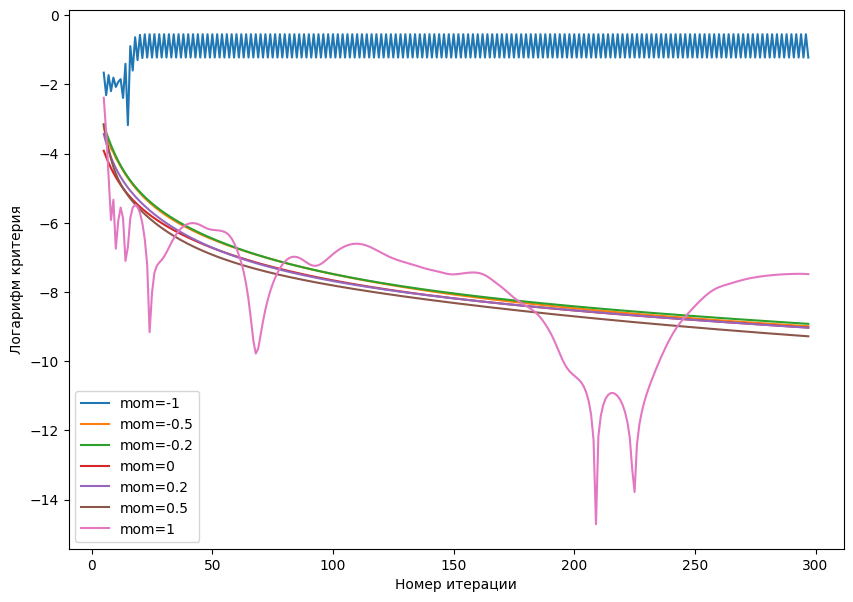

In [15]:
moms = [-1, -0.5, -0.2, 0, 0.2, 0.5, 1]
def risovach(moms, iters=300):
    plt.figure(figsize=(10, 7))
    for mom in moms:
        w_temp, f_temp = heavy_ball(mom=mom, iters=iters)
        err = [abs(f_temp[k+1] - f_temp[k]) for k in range(5, iters-2)]

        w = w_temp[-1]
        _, xx = acc_score(w)
        print(f"Test accuracy: {xx}, Momentum: {mom} \n")

        plt.plot(range(5, iters-2), np.log(err), label=f'mom={mom}')

    plt.xlabel("Номер итерации")
    plt.ylabel("Логарифм критерия")
    plt.legend(fontsize=10)
    plt.show()

risovach(moms) 

Сходимость при некоторых значениях моментума может быть немонотонной. Видим, что отрицательные значения нам не подходят. Если моментум близок к 1, сходимость не является монотонной. Поищем повнимательнее оптимальный моментум на промежутке $[0.5, 1]$.

Finished at:
f(w) = 0.0329966362042368
Test accuracy: 0.9827692307692307, Momentum: 0.6 

Finished at:
f(w) = 0.025503830160392784
Test accuracy: 0.9889230769230769, Momentum: 0.7 

Finished at:
f(w) = 0.018842895589867553
Test accuracy: 0.9944615384615385, Momentum: 0.8 

Finished at:
f(w) = 0.014166482695371714
Test accuracy: 0.9963076923076923, Momentum: 0.85 

Finished at:
f(w) = 0.00888916688755254
Test accuracy: 0.9987692307692307, Momentum: 0.9 

Finished at:
f(w) = 0.0037351853481173668
Test accuracy: 0.9993846153846154, Momentum: 0.95 



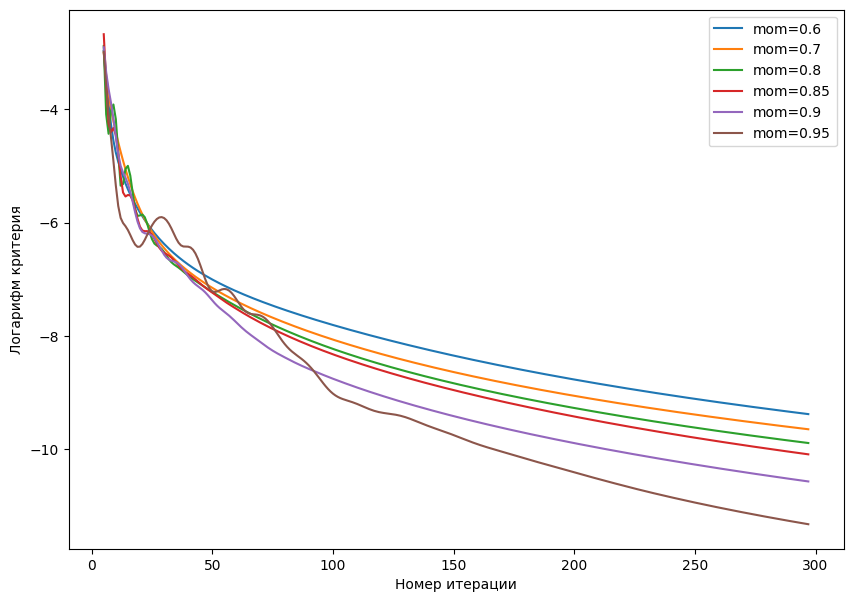

In [16]:
moms = [0.6, 0.7, 0.8, 0.85, 0.9, 0.95]
risovach(moms)

В качестве оптимального значения возьмем $0.95$.

__(в)__ Для лучшего значения моментума постройте график зависимости точности модели на тестовой выборке от времени работы метода. Добавьте на этот же график сходимость градиентного спуска с шагом $\frac{1}{L}$. Сделайте вывод.

In [18]:
w_hb, f_hb = heavy_ball(mom=0.95, iters=2000)

Finished at:
f(w) = 0.0006404240411251503


In [19]:
w_gd, f_gd = grad_descent(iters=2000)

Finished at:
 f(w*) = 0.013650145840899967


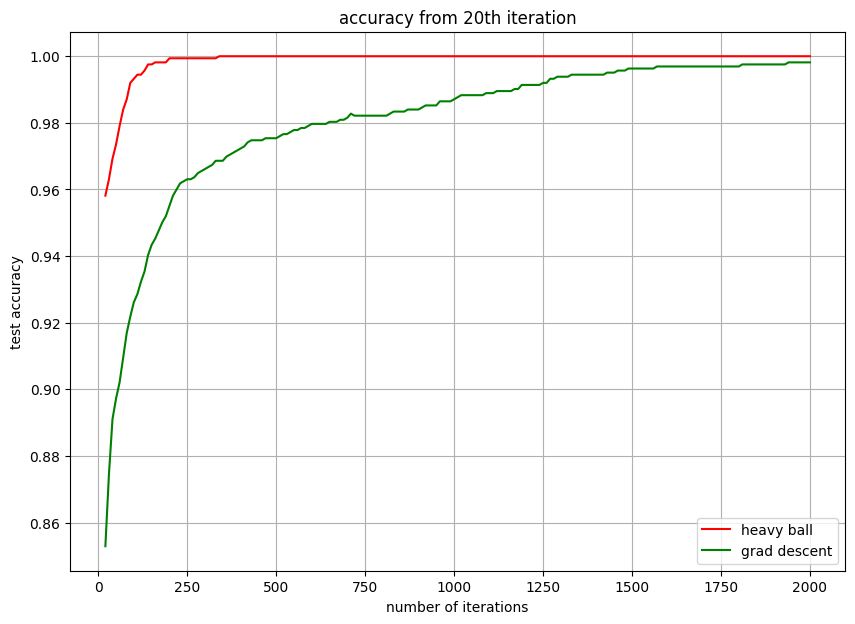

In [32]:
acc = list()
acc1 = list()
n = list()
for i in range(20, len(w_hb), 10):
    w = w_hb[i]
    n.append(i)
    acc.append(accuracy_score(y_test, np.around(2 / (1 + np.exp(- X_test @ w))) - 1))
    w1 = w_gd[i]
    acc1.append(accuracy_score(y_test, np.around(2 / (1 + np.exp(- X_test @ w1))) - 1))

plt.figure(figsize=(10, 7))
plt.plot(n, acc, color='red', label='heavy ball')
plt.plot(n, acc1, color='green', label='grad descent')
plt.title("accuracy from 20th iteration")
plt.xlabel("number of iterations")
plt.ylabel("test accuracy")
plt.legend(fontsize=10)
plt.grid()
plt.show()

Видим, что точность метода тяжелого шарика возрастает быстрее.

__(г)__ Если в пунктах (б) и (в) столкнулись с проблемами, попробуйте $\ell_2$-регуляризовать задачу или рассмотреть ее на ограниченном множестве.

__(д)__ Реализуйте ускоренный метод Нестерова (в форме Нестерова, а не который доказывали на семинаре). 

In [25]:
def mom_k(k, a):
    return k/(k+a)

def nesterov_acceleration(gamma=1/L, mom=None, a=None, iters=1000):

    w0 = np.random.uniform(low=-L/5, high=L/5, size=(d,))
    w1 = w0
    w2 = w0/1.1
    w_vals = [w2, w1]
    f_vals = [f(w2, X=X_train, y=y_train), f(w1, X=X_train, y=y_train)]
    
    # да-да...
    if a:
        for i in range(iters):
            y = w1 + mom_k(i, a) * (w1 - w2)
            w = y - gamma * grad(y, X=X_train, y=y_train)
            w2 = w1
            w1 = w
            w_vals.append(w)
            f_vals.append(f(w, X=X_train, y=y_train))
    
    if mom:
        for i in range(iters):
            y = w1 + mom * (w1 - w2)
            w = y - gamma * grad(y, X=X_train, y=y_train)
            w2 = w1
            w1 = w
            w_vals.append(w)
            f_vals.append(f(w, X=X_train, y=y_train))

    print(f'Finished at: \n f(w*) = {f_vals[-1]}')
    return w_vals, f_vals

__(е)__ Решите задачу логистической регресии с помощью метода Нестерова (не забудьте разделить выборку на две части: обучающую и тестовую). Зафиксируйте шаг $\frac{1}{L}$ и перебирайте разные значения моментума от -1 до 1. Проверьте также значения моментума равные $\frac{k}{k+3}$, $\frac{k}{k+2}$, $\frac{k}{k+1}$ ($k$ - номер итерации), а если решаете сильно выпуклую задачу, то и $\frac{\sqrt{L} - \sqrt{\mu}}{\sqrt{L} + \sqrt{\mu}}$. Постройте график сходимости метода от числа итераций (критерий сходимости подберите самостоятельно) для различных значений моментума. Всегда ли сходимость является монотонной?

Finished at: 
 f(w*) = 0.04059855718163791
Finished at: 
 f(w*) = 0.03167990438590573
Finished at: 
 f(w*) = 0.02003863897829576
Finished at: 
 f(w*) = 0.008837911380871635
Finished at: 
 f(w*) = 0.0001915876925239141
Finished at: 
 f(w*) = 0.0008346727461234175
Finished at: 
 f(w*) = 0.0015716817580783116


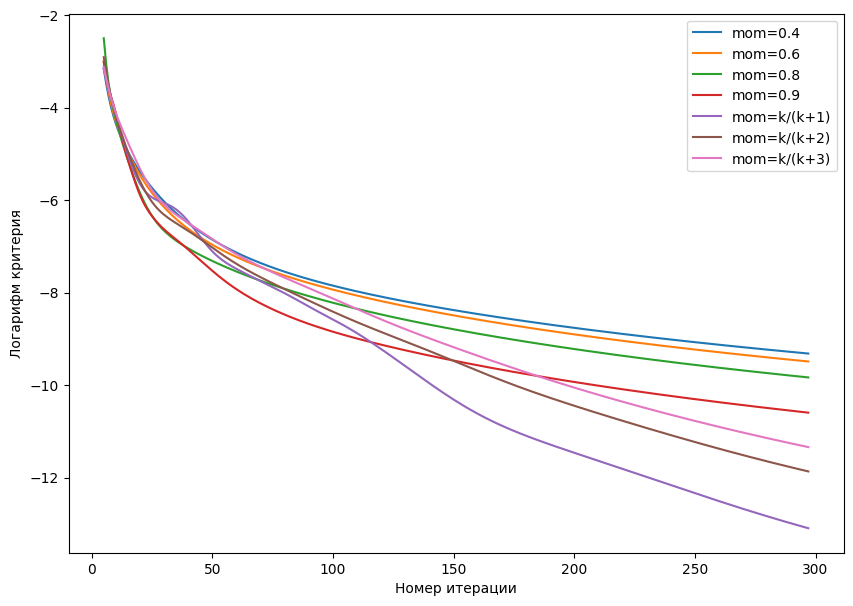

In [30]:
# постоянные положительные моменты
moms = [0.4, 0.6, 0.8, 0.9]
plt.figure(figsize=(10, 7))
for mom in moms:
    i = 300
    w_temp, f_temp = nesterov_acceleration(mom=mom, iters=i)
    err = [abs(f_temp[k+1] - f_temp[k]) for k in range(5, i-2)]
    plt.plot(range(5, i-2), np.log(err), label=f'mom={mom}')

# меняющиеся от итерации моменты
roms = [1, 2, 3]
for rom in roms:
    i = 300
    w_temp, f_temp = nesterov_acceleration(a=rom, iters=i)
    err = [abs(f_temp[k+1] - f_temp[k]) for k in range(5, i-2)]
    plt.plot(range(5, i-2), np.log(err), label=f'mom=k/(k+{rom})')

plt.xlabel("Номер итерации")
plt.ylabel("Логарифм критерия")
plt.legend(fontsize=10)
plt.show()

Видим, что алгоритм Нестерова, в отличие от метода тяжелого шарика, хорошо относится к большим значениям моментума: график сходимости куда более гладкий при mom $\approx 1$.

Среди постоянных моментумов лучше всех себя показал наибольший, ровно как и среди переменных: $\dfrac{k}{k+1}$.

__(ж)__ Для лучшего значения моментума постройте график зависимости точности модели на тестовой выборке от времени работы метода. Добавьте этот график к графикам для тяжелого шарика и градиентного спуска из пункта (г). Сделайте итоговый вывод.

In [27]:
w_na, f_na = nesterov_acceleration(a=1, iters=2000)

Finished at: 
 f(w*) = 4.123680888633742e-07


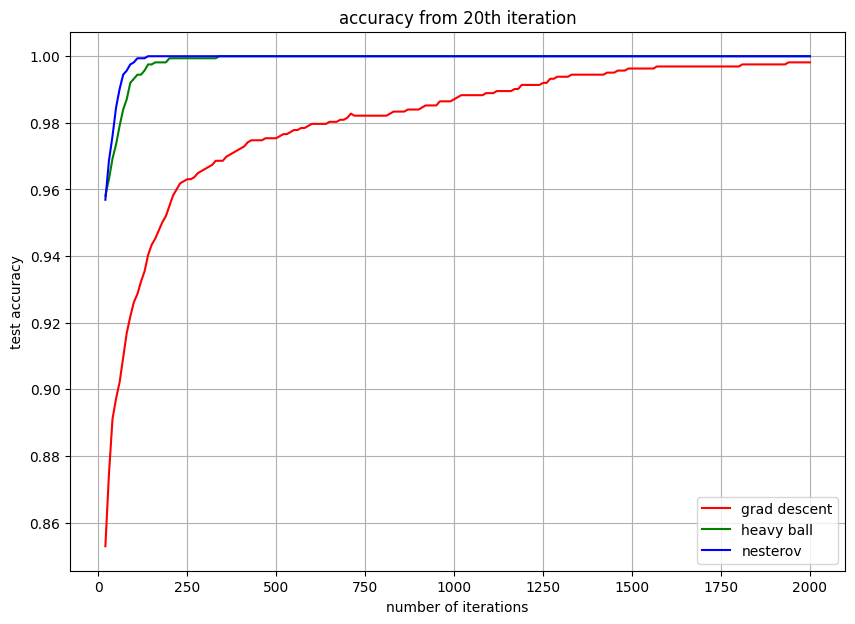

In [33]:
acc_gd = list()
acc_hb = list()
acc_na = list()
n = list()
for i in range(20, len(w_hb), 10):
    n.append(i)
    w = w_gd[i]
    acc_gd.append(accuracy_score(y_test, np.around(2 / (1 + np.exp(- X_test @ w))) - 1))
    w1 = w_hb[i]
    acc_hb.append(accuracy_score(y_test, np.around(2 / (1 + np.exp(- X_test @ w1))) - 1))
    w2 = w_na[i]
    acc_na.append(accuracy_score(y_test, np.around(2 / (1 + np.exp(- X_test @ w2))) - 1))

plt.figure(figsize=(10, 7))
plt.plot(n, acc_gd, color='red', label='grad descent')
plt.plot(n, acc_hb, color='green', label='heavy ball')
plt.plot(n, acc_na, color='blue', label='nesterov')

plt.title("accuracy from 20th iteration")
plt.xlabel("number of iterations")
plt.ylabel("test accuracy")
plt.legend(fontsize=10)
plt.grid()
plt.show()

Нестеров победил!!!

__Бонусные пункт__

__(з)__ Сделаем подбор константы $L$ адаптивным. Как упоминалось на семинаре, можно измерять локальную $L$, используя:
$$
f(y) \leq f(x^k) + \langle \nabla f(x^k), y - x^k \rangle + \frac{L}{2}\|x^k - y\|_2^2
$$
В частности, может подойти процедура:

```python
def backtracking_L(f, grad, x, h, L0, rho):
    L = L0
    fx = f(x)
    gradx = grad(x)
    while True:
        y = x - 1 / L * h
        if f(y) <= fx - 1 / L gradx.dot(h) + 1 / (2 * L) h.dot(h):
            break
        else:
            L = L * rho
    return L
```

Каким стоит взять __h__? __rho__ должно быть больше или меньше 1? __L0__ надо брать заведомо большим или маленьким?

Мы хотим оценивать $L$ локально, поэтому стоит $h$ выбирать из этих соображений. Например, чтобы выполнялось $\|x - y\| \leq \frac{1}{L}$. Для этого пойдет $\|h\| \leq 1$. 

Ясно, что при больших значениях $L_0$ неравенство заведомо выполнено, поэтому будем стартовать с небольших значений, например, 0.1. Чтобы значение плавно росло будем брать небольшой $\rho > 1$, например, 1.2.

In [36]:
def backtracking_L(x, h, L0, rho):
    L = L0
    fx = f(x)
    gradx = grad(x)
    while True:
        y = x - 1 / L * h
        if f(y) <= fx - 1 / L * gradx.T @ h + 1 / (2 * L) * h.T @ h:
            break
        else:
            L = L * rho
    return L

__(и)__ Поэксперементируйте с этой процедурой, встроенной в подбор $L$ для шага градиентного спуска. В качестве задачи продолжайте рассматривать логистическую регрессию из Задачи 1. Аналогично встройте процедуру подбора $L$ в метод тяжелого шарика и ускоренный метод Нестерова. Постройте график сходимости метода от числа итераций (критерий сходимости подберите самостоятельно). Отобразите на этом графике градиентный спуск, тяжелый шарик и метод Нестерова с адаптивным шагом и шагом $\frac{1}{L}$ (всего 6 линий на графике). Сделайте вывод.

In [52]:
w0 = np.random.uniform(low=-L/5, high=L/5, size=(d,))

In [79]:
def error(x):
    return np.linalg.norm(grad(x), ord=2)

def hb_adapt(h, L0, rho, mom, iters=1000):

    w1 = w0
    w2 = w0/1.1
    w_vals = [w2, w1]
    errs = [error(w2), error(w1)]

    for i in range(1, iters):
        w = w1 - 1 / backtracking_L(w1, h, L0, rho) * grad(w1, X=X_train, y=y_train) + mom * (w1 - w2)
        w2 = w1
        w1 = w
        w_vals.append(w)
        errs.append(error(w1))
    
    return w_vals, errs

def na_adapt(h, L0, rho, mom, iters=1000):

    w1 = w0
    w2 = w0/1.1
    w_vals = [w2, w1]
    errs = [error(w2), error(w1)]

    for i in range(iters):
        y = w1 + mom * (w1 - w2)
        w = y - 1 / backtracking_L(w1, h, L0, rho) * grad(y, X=X_train, y=y_train)
        w2 = w1
        w1 = w
        w_vals.append(w)
        errs.append(error(w1))

    return w_vals, errs

In [62]:
def risovach(errs, labels, title):

    plt.figure(figsize=(9, 6))
    for e, l in zip(errs, labels):
        plt.plot(range(len(e)), np.log(e), label=l)
    plt.xlabel("Номер итерации")
    plt.ylabel("Логарифм критерия")
    plt.title(title)
    plt.legend(fontsize=12)
    plt.show()

In [85]:
iters = 200
h = np.random.uniform(-1/d, 1/d, size=(d,))

L0_0, rho_0 = 0.01, 1.2
w_0, errs_0 = hb_adapt(h, L0_0, rho_0, mom=0.9, iters=iters)
L0_1, rho_1 = 0.01, 1.5
w_1, errs_1 = hb_adapt(h, L0_1, rho_1, mom=0.9, iters=iters)
L0_x, rho_x = 0.01, 2
w_x, errs_x = hb_adapt(h, L0_x, rho_x, mom=0.9, iters=iters)

L0_2, rho_2 = 0.1, 1.2
w_2, errs_2 = hb_adapt(h, L0_2, rho_2, mom=0.9, iters=iters)
L0_3, rho_3 = 0.5, 1.1
w_3, errs_3 = hb_adapt(h, L0_3, rho_3, mom=0.9, iters=iters)

In [104]:
iters = 200
h = np.random.uniform(-1/d, 1/d, size=(d,))

L0_0, rho_0 = 0.01, 1.2
w_0_, errs_0_ = na_adapt(h, L0_0, rho_0, mom=0.9, iters=iters)

L0_2, rho_2 = 0.1, 1.2
w_2_, errs_2_ = na_adapt(h, L0_2, rho_2, mom=0.9, iters=iters)
L0_x, rho_x = 0.01, 1.5
w_x_, errs_x_ = na_adapt(h, L0_x, rho_x, mom=0.9, iters=iters)

L0_3, rho_3 = 0.5, 1.2
w_3_, errs_3_ = na_adapt(h, L0_3, rho_3, mom=0.9, iters=iters)

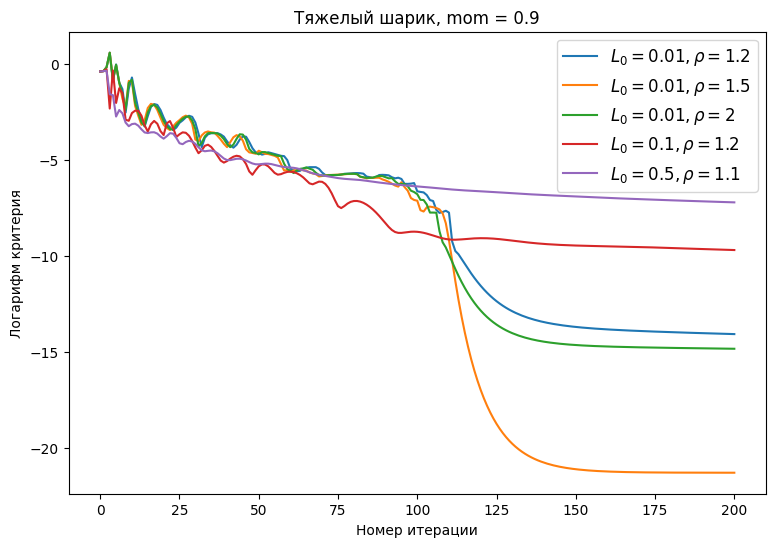

In [98]:
risovach(errs=[errs_0, errs_1, errs_x, errs_2, errs_3],
         labels=[r'$L_0 = 0.01, \rho = 1.2$', r'$L_0 = 0.01, \rho = 1.5$', r'$L_0 = 0.01, \rho = 2$',
                  r'$L_0 = 0.1, \rho = 1.2$', r'$L_0 = 0.5, \rho = 1.1$'], 
         title='Тяжелый шарик, mom = 0.9')

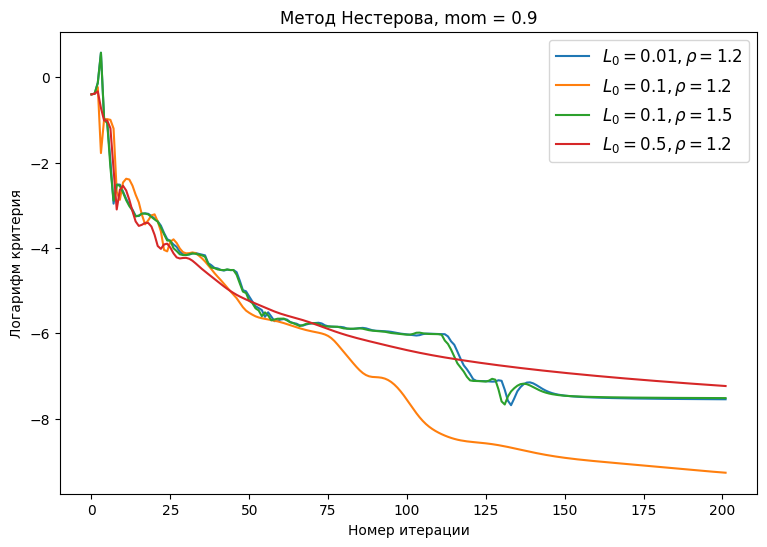

In [105]:
risovach(errs=[errs_0_, errs_2_, errs_x_, errs_3_],
         labels=[r'$L_0 = 0.01, \rho = 1.2$', r'$L_0 = 0.1, \rho = 1.2$',
                  r'$L_0 = 0.1, \rho = 1.5$', r'$L_0 = 0.5, \rho = 1.2$'], 
         title='Метод Нестерова, mom = 0.9')

Результаты разнятся: в методе тяжелого шарика победили параметры $L_0 = 0.01, \rho = 1.5$, в методе Нестерова - $L_0 = 0.1, \rho = 1.2$.

__(к)__ Постройте аналогичный пункту (и) график точности модели от времени.

In [ ]:
#ответ

__(л)__ В [работе](https://arxiv.org/pdf/1204.3982.pdf) представлена техника рестартов для подавления немонотонной сходимости Алгоритма 2 (метод Нестерова). Попробуйте повторить эксперименты авторов на $\ell_2$-регуляризованной квадратичной или логистической регресии. Возьмите параметр регуляризации $\lambda = L / 100$.

In [ ]:
#ответ